# Exploratory Analysis 

1. **Driver Attributes vs. Accident Risk**  
   - Question: Are certain driver attributes (age, rating, experience) correlated with higher accident frequency or cost?  
   - Data: `driver_data_df`, filtered `service_type_df` for `claim_type == 'Accident'` (merged on `driver_id`), `vehicle_driver_df`

2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

3. **Vehicle Age & Claim Patterns**  
   - Question: How does vehicle age impact accident frequency, accident cost, and downtime?  
   - Data: `vehicle_data_df` (vehicle_age), `service_type_df`, `vehicle_driver_df`

4. **Fuel Type & Operating Risk**  
   - Question: Do petrol, diesel, hybrid, or electric vehicles differ in accident rate or cost when adjusted for usage?  
   - Data: `vehicle_data_df` (type), merged accident and trip data

5. **Time-Series Drivers of Cost**  
   - Question: Are there seasonal or monthly patterns in accident frequency or cost across the fleet?  
   - Data: `service_type_df` (event_date grouped by month), `profit_vehicles_df`

6. **Downtime Drivers**  
   - Question: What factors (claims type, vehicle type, driver) drive longer downtime per incident?  
   - Data: `merge_service_vehicle_driver` (`downtime_hours`), plus vehicle and driver attributes

7. **Cost vs. Revenue Trade‑offs**  
   - Question: How does high-risk (costly) vehicle or driver segments correlate with profitability?  
   - Data: Combined `profit_vehicles_df`, accident cost data, trip revenue

8. **Predictors of High-Cost Incidents**  
   - Question: Can we build a simple model to predict which incidents (or drivers) will exceed a cost threshold?  
   - Data: All incident-level attributes from `service_type_df`, driver and vehicle features

9. **Impact of Contract Terms**  
   - Question: Do drivers on different contract lengths or rent tiers show different accident or revenue patterns?  
   - Data: `vehicle_driver_df` (contract_start/end), rental rate data (if available)

10. **Cost‑Saving Scenario Analysis**  
    - Question: What % cost savings could the business realize by, for example, rotating out vehicles older than X years or retraining drivers in the top risk quartile?  
    - Data: Use your descriptive cost and usage summaries to model “what if” scenarios; this may be best done in a separate **Scenario Analysis** or **Forecasting** file.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
driver_data_df=pd.read_csv('../data/drivers_data.csv')
vehicle_driver_df = pd.read_csv("../data/vehicle_driver_assignment.csv")
profit_vehicles_df = pd.read_csv("../data/profit_per_vehicle.csv")
vehicle_data_df = pd.read_csv("../data/vehicles_data.csv")
maintenance_cost = pd.read_csv("../data/material_usage_per_vehicle.csv")

service_type_df= pd.read_csv("../data/service_type.csv") 

vehicle_profit_df= pd.read_csv('../data/profit_per_vehicle.csv')

trip_logs_df = pd.read_csv("../data/trip_logs.csv")

In [46]:

result.columns

group_by_accident_events=(
    result
    .groupby(['driver_id','vehicle_id','name','age'])['event_id']
    .count()
    .reset_index(name='event_count')
    .sort_values(by='event_count',ascending=False)
)


group_by_accident_events.head(20)

,driver_id,vehicle_id,name,age,event_count
30,D0045,V0045,Anthony Deep,39,7
13,D0021,V0021,Oliver Singhal,28,6
23,D0036,V0036,Max Varughese,28,5
10,D0017,V0017,Brian Flores,38,4
33,D0048,V0048,Faraj Bedi,26,4
35,D0050,V0050,Michael Guerra,27,4
11,D0018,V0018,Bakhshi Mody,37,4
32,D0047,V0047,Laksh Choudhary,34,4
26,D0039,V0039,Anmol Date,34,4
21,D0034,V0034,Banjeet Kanda,47,3


In [47]:
accidents_df = service_type_df[service_type_df['claim_type'] == 'Accident']

merged = pd.merge(accidents_df, vehicle_driver_df, on='vehicle_id', how='left')

## filter rows ehere the event_data fails withing the drivers contract period 
filtered = merged[(merged['event_date'] >= merged['contract_start']) & (merged['event_date'] <= merged['contract_end'])]


filtered.columns
filtered['driver_id']= filtered['driver_id_y']
filtered = filtered.drop(columns=['driver_id_x','driver_id_y'])
## merge with driver details 
result = pd.merge(filtered, driver_data_df, on='driver_id', how='left')


accident_costs_per_driver = (
    result.groupby(['driver_id','name','age'])['cost']
    .sum()
    .reset_index()
    .sort_values(by='cost', ascending=False)
)
accident_costs_per_driver.head(20)


C:\Users\yeahm\AppData\Local\Temp\ipykernel_13292\1977160117.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['driver_id']= filtered['driver_id_y']


,driver_id,name,age,cost
30,D0045,Anthony Deep,39,4966
33,D0048,Faraj Bedi,26,4906
10,D0017,Brian Flores,38,4842
13,D0021,Oliver Singhal,28,4737
23,D0036,Max Varughese,28,4142
32,D0047,Laksh Choudhary,34,3780
26,D0039,Anmol Date,34,3258
16,D0028,Samar Kunda,47,2901
11,D0018,Bakhshi Mody,37,2892
15,D0023,Ojas Shan,48,2803


In [48]:






result.columns

merge_driver_trip_log= pd.merge(trip_logs_df,driver_data_df, on='driver_id' ,how='inner')

merge_driver_trip_log.columns

## First aggregate trip count based on driver_id 
group_by_trip_count=(
    merge_driver_trip_log
    .groupby(['driver_id'])['trip_id']
    .count()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count',ascending=False)
)

## next aggregate by total milage 
group_by_total_mileage=(
    merge_driver_trip_log
    .groupby(['driver_id'])['distance_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values(by='total_mileage',ascending=False)
)

group_by_trip_count.head()
group_by_total_mileage.head()

result = result.merge(group_by_trip_count, on='driver_id', how='left')
result = result.merge(group_by_total_mileage, on='driver_id', how='left')

## 1. Are certain driver attributes (e.g., age, rating, experience) correlated with higher accident frequency or cost?
* Relevant tables:drivers_data, service_type (claim_type == 'Accident' with driver_id),vehicle_driver_assignments

In [49]:
result.columns

result['contract_end'] = pd.to_datetime(result['contract_end'],errors='coerce')

result['contract_start'] = pd.to_datetime(result['contract_start'],errors='coerce')
result['contract_days']= (result['contract_end']-result['contract_start']).dt.days
#compute experience
result['experience']=(
    result['contract_days'].fillna(0)*0.5+
    result['trip_count'].fillna(0)*1+
    result['total_mileage'].fillna(0)*0.01
)



In [50]:
## accident frequency per driver 
# Accident frequency per driver
accident_freq = result.groupby('driver_id').size().reset_index(name='accident_frequency')

## Accident  cost per driver 
accident_cost = result.groupby('driver_id')['cost'].sum().reset_index(name='accident_cost')

accident_freq.head()
accident_cost.head()

,driver_id,accident_cost
0,D0001,2065
1,D0002,2448
2,D0005,1325
3,D0007,1175
4,D0008,813


In [51]:
print(result[['driver_id']].head())
print(result['driver_id'].nunique())
print(accident_freq.head())



  driver_id
0     D0001
1     D0001
2     D0002
3     D0002
4     D0005
36
  driver_id  accident_frequency
0     D0001                   2
1     D0002                   2
2     D0005                   2
3     D0007                   1
4     D0008                   1


object
object
count    72.000000
mean      3.152778
std       1.683890
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       7.000000
Name: accident_frequency, dtype: float64
7


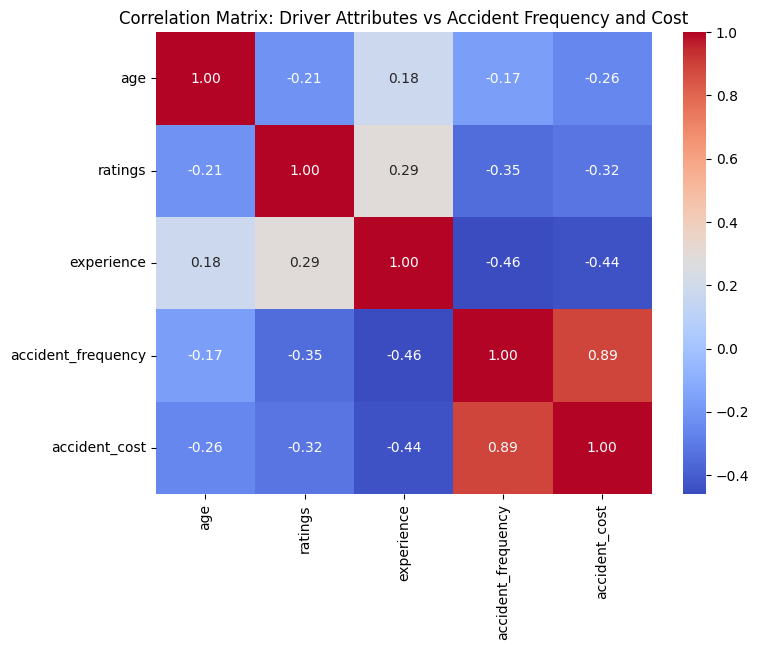

,age,ratings,experience,accident_frequency,accident_cost
age,1.000000,-0.210991,0.176141,-0.166146,-0.260206
ratings,-0.210991,1.000000,0.289883,-0.350980,-0.319363
experience,0.176141,0.289883,1.000000,-0.460349,-0.438323
accident_frequency,-0.166146,-0.350980,-0.460349,1.000000,0.889414
accident_cost,-0.260206,-0.319363,-0.438323,0.889414,1.000000


In [52]:
## Merge them 

## select driver attributes 1 row per driver 
drivers = result[['driver_id','age','ratings','experience']].drop_duplicates()

print(drivers['driver_id'].dtype)
print(accident_freq['driver_id'].dtype)
## merge accident frequency and cost 

driver_accident_stats = drivers.merge(accident_freq,on='driver_id',how='left').merge(accident_cost,on='driver_id',how='left')


# Fill NaN (drivers with zero accidents)
driver_accident_stats['accident_frequency'] = driver_accident_stats['accident_frequency'].fillna(0)
driver_accident_stats['accident_cost'] = driver_accident_stats['accident_cost'].fillna(0)

print(driver_accident_stats['accident_frequency'].describe())
print(driver_accident_stats['accident_frequency'].nunique())
## Calculate correlations 

correlations = driver_accident_stats[['age','ratings','experience','accident_frequency','accident_cost']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Driver Attributes vs Accident Frequency and Cost')
plt.show()
correlations.head()

### Key Insights

- **Age** shows a mild negative correlation with accident frequency and cost, suggesting older drivers may have fewer and less costly accidents.
- **Driver ratings** are inversely related to accident frequency and costs, indicating higher-rated drivers tend to be safer.
- **Experience** is strongly negatively correlated with accident frequency and cost, highlighting the benefit of driving experience in reducing accidents and related expenses.
- Accident frequency and cost have a strong positive correlation, confirming that more accidents generally lead to higher total accident costs.

These correlations suggest that driver experience and ratings are important factors in predicting accident risk and associated costs.

In [7]:
result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'assignment_id',
       'contract_start', 'contract_end', 'driver_id', 'name', 'age',
       'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience'],
      dtype='object')

## 2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

In [8]:
## compute accident count per driver 


accident_counts = (
    result
    .groupby(['driver_id', 'name', 'age'])['event_id']
    .nunique()
    .reset_index(name='accident_count')
)

# Merge it in
result = result.drop_duplicates(subset=['driver_id', 'name', 'age']) \
               .merge(accident_counts, on=['driver_id','name','age'], how='left')

In [19]:
## aggregate to 1 row per driver 
# Starting from your 'result' DataFrame with one row per accident event
driver_summary = (
    result
    .groupby(['driver_id', 'name', 'age', 'ratings', 'experience'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'cost':         'sum'                  # total accident cost
    })
    .rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles',
        'cost':          'total_accident_cost'
    })
    .reset_index()
)

### normalize and calculate rate 

driver_summary['accidents_per_trip'] = driver_summary['accident_count'] / driver_summary['total_trips']
driver_summary['accidents_per_mile'] = driver_summary['accident_count'] / driver_summary['total_miles']
driver_summary['cost_per_mile']      = driver_summary['total_accident_cost'] / driver_summary['total_miles']


fleet_avg_accidents_per_trip = driver_summary['accident_count'].sum() / driver_summary['total_trips'].sum()


In [24]:




## Identify high risk drivers 

risk_by_trip = driver_summary.sort_values('accidents_per_trip',ascending=False)

risk_by_cost = driver_summary.sort_values('cost_per_mile',ascending=False)


risk_by_trip= risk_by_trip[risk_by_trip['accidents_per_trip']> fleet_avg_accidents_per_trip]



 * Which drivers are linked to the highest total accident-related costs?
 - In our descriptive analysis we got this table for the driver that had the largest accident related cost 
- | Rank | Driver ID | Name            | Age | Total Accident Cost (£) |
- |------|-----------|-----------------|-----|--------------------------|
- | 1    | D0045     | Anthony Deep    | 39  | 4,966                    |
- | 2    | D0048     | Faraj Bedi      | 26  | 4,906                    |
- | 3    | D0017     | Brian Flores    | 38  | 4,842                    |
- | 4    | D0021     | Oliver Singhal  | 28  | 4,737                    |
- | 5    | D0036     | Max Varughese   | 28  | 4,142                    |

* At first glance, Anthony Deep appears to be the most costly driver. However, this table does not consider how much each driver actually drove, some may simply have had more exposure.


* When normalized by trips and mileage, Anthony Deep doesn’t appear in the top 5 riskiest drivers. Instead, drivers like Gopal Sathe and Mithesh batta emerge as higher-risk due to their elevated cost and incident rate per mile or trip.


* Gopal Sathe for example has a cost-per-trip rate £0.24, then:

Over 300 trips → ~£72 total accident-related cost

Over 500 trips → ~£120 total accident-related cost

In [31]:

risk_by_trip.shape[0]  # number of rows (drivers) above average
risk_by_trip.head(5)

,driver_id,name,age,ratings,experience,accident_count,total_trips,total_miles,total_accident_cost,accidents_per_trip,accidents_per_mile,cost_per_mile
23,D0036,Max Varughese,28,3.60,745.5828,1,669,7008.28,831,0.001495,0.000143,0.118574
27,D0041,Tejas Memon,48,3.58,752.5190,1,675,7051.90,574,0.001481,0.000142,0.081397
16,D0028,Samar Kunda,47,4.12,756.5924,1,681,6759.24,857,0.001468,0.000148,0.126789
1,D0002,Vincent Lad,40,3.56,765.5686,1,686,7456.86,924,0.001458,0.000134,0.123913
32,D0047,Laksh Choudhary,34,3.88,765.3257,1,686,7132.57,1230,0.001458,0.000140,0.172448


About 40% of our drivers have an accident rate above the fleet average.
This indicates that a significant portion of our drivers contribute disproportionately to accident risk, one suggestion is  focusing on safety and training efforts on this group to reduce overall incidents.